# **Fine-tuning for Image Classification of Indian Food with 🤗 Transformers**

This [notebook at https://bit.ly/raj_foodimage](https://bit.ly/raj_foodimage) shows how to fine-tune a pretrained Vision model for Image Classification on an Indian Food dataset. The idea is to add a randomly initialized classification head on top of a pre-trained encoder, and fine-tune the model altogether on a labeled dataset.

## ImageFolder

This notebook leverages the [ImageFolder](https://huggingface.co/docs/datasets/v2.0.0/en/image_process#imagefolder) feature to easily run the notebook on a custom dataset. You can either load a `Dataset` from local folders or from local/remote files, like zip or tar.

## Any model

This notebook is built to run on any image classification dataset with any vision model checkpoint from the [Model Hub](https://huggingface.co/) as long as that model has a version with a Image Classification head, such as:
* [ViT](https://huggingface.co/docs/transformers/model_doc/vit#transformers.ViTForImageClassification)
* [Swin Transformer](https://huggingface.co/docs/transformers/model_doc/swin#transformers.SwinForImageClassification)
* [ConvNeXT](https://huggingface.co/docs/transformers/master/en/model_doc/convnext#transformers.ConvNextForImageClassification)

- in short, any model supported by [AutoModelForImageClassification](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForImageClassification).

## Data augmentation

This notebook leverages Torchvision's [transforms](https://pytorch.org/vision/stable/transforms.html) for applying data augmentation - note that we do provide alternative notebooks which leverage other libraries, including:

* [Albumentations](https://github.com/huggingface/notebooks/blob/main/examples/image_classification_albumentations.ipynb)
* [Kornia]((https://github.com/huggingface/notebooks/blob/main/examples/image_classification_kornia.ipynb))
* [imgaug]((https://github.com/huggingface/notebooks/blob/main/examples/image_classification_imgaug.ipynb)). 

---

Depending on the model and the GPU you are using, you might need to adjust the batch size to avoid out-of-memory errors. Set those two parameters, then the rest of the notebook should run smoothly.

In this notebook, we'll fine-tune from the https://huggingface.co/microsoft/swin-tiny-patch4-window7-224 checkpoint, but note that there are many, many more available on the [hub](https://huggingface.co/models?other=vision).

Before we start, let's install the `datasets` and `transformers` libraries.

In [ ]:
!pip install -q datasets transformers
import os

     |████████████████████████████████| 365 kB 7.1 MB/s 
     |████████████████████████████████| 4.7 MB 64.3 MB/s 
     |████████████████████████████████| 115 kB 76.6 MB/s 
     |████████████████████████████████| 141 kB 76.9 MB/s 
     |████████████████████████████████| 212 kB 66.6 MB/s 
     |████████████████████████████████| 101 kB 10.8 MB/s 
     |████████████████████████████████| 596 kB 71.8 MB/s 
     |████████████████████████████████| 127 kB 76.6 MB/s 
     |████████████████████████████████| 6.6 MB 42.7 MB/s 


If you're opening this notebook locally, make sure your environment has an install from the last version of those libraries.

To be able to share your dataset and model with the community and generate results like the one shown in the picture below via the inference API, there are a few more steps to follow.

First you have to store your authentication token from the Hugging Face website (sign up [here](https://huggingface.co/join) if you haven't already!) then execute the following cell and input your token:

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store



Then you need to install Git-LFS to upload your model checkpoints:

In [ ]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

## Importing data into Hugging Face hub and datasets (optional)

The following is how you start with raw images and upload them into Hugging Face datasets.  For this project, if you just want to start training on the indian foods dataset, you can skip this portion of the notebook.
I started by gettig the raw image data from [Kaggle](https://www.kaggle.com/datasets/l33tc0d3r/indian-food-classification?resource=download-directory).  I put the images into my Google drive and copied it over to my Google Colab instance.  You will have to change the origin folder to your location 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unzip "/content/drive/MyDrive/Data2/Food Classification.zip" -d /tmp/foodimg


Streaming output truncated to the last 5000 lines.
  inflating: /tmp/foodimg/chapati/253.jpg  
  inflating: /tmp/foodimg/chapati/254.jpg  
  inflating: /tmp/foodimg/chapati/255.jpg  
  inflating: /tmp/foodimg/chapati/256.jpg  
  inflating: /tmp/foodimg/chapati/257.jpg  
  inflating: /tmp/foodimg/chapati/258.jpg  
  inflating: /tmp/foodimg/chapati/259.jpg  
  inflating: /tmp/foodimg/chapati/260.jpg  
  inflating: /tmp/foodimg/chapati/261.jpg  
  inflating: /tmp/foodimg/chapati/262.jpg  
  inflating: /tmp/foodimg/chapati/263.jpg  
  inflating: /tmp/foodimg/chapati/264.jpg  
  inflating: /tmp/foodimg/chapati/265.jpg  
  inflating: /tmp/foodimg/chapati/266.jpg  
  inflating: /tmp/foodimg/chapati/267.jpg  
  inflating: /tmp/foodimg/chapati/268.jpg  
  inflating: /tmp/foodimg/chapati/269.jpg  
  inflating: /tmp/foodimg/chapati/270.jpg  
  inflating: /tmp/foodimg/chapati/271.jpg  
  inflating: /tmp/foodimg/chapati/272.jpg  
  inflating: /tmp/foodimg/chapati/273.jpg  
  inflating: /tmp/foodimg

We will use the [🤗 Datasets](https://github.com/huggingface/datasets) library's [ImageFolder](https://huggingface.co/docs/datasets/v2.0.0/en/image_process#imagefolder) feature to download our custom dataset into a DatasetDict.

In [ ]:
from datasets import load_dataset 
ds = load_dataset("imagefolder", data_dir="/tmp/foodimg")
ds = ds['train']

Resolving data files:   0%|          | 0/6271 [00:00<?, ?it/s]

Using custom data configuration default-ed008ccd80f367aa


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/default-ed008ccd80f367aa/0.0.0/0fc50c79b681877cc46b23245a6ef5333d036f48db40d53765a68034bc48faff. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

I next want to randomly created a test split for validating the model

In [ ]:
data = ds.train_test_split(test_size=0.15)

In [ ]:
data

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 5328
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 941
    })
})

Let's now push this dataset to the Hugging face public hub.  This provides a place where this data is saved and can always be called back later.  You should change the location from `rajistics` to your account.

In [ ]:
data.push_to_hub("rajistics/indian_food_images")

Pushing split train to the Hub.


  0%|          | 0/6 [00:00<?, ?ba/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:1951: FutureWarning: `identical_ok` has no effect and is deprecated. It will be removed in 0.11.0.
  FutureWarning,


Deleting unused files from dataset repository:   0%|          | 0/1 [00:00<?, ?it/s]

Pushing split test to the Hub.


  0%|          | 0/1 [00:00<?, ?ba/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Deleting unused files from dataset repository:   0%|          | 0/1 [00:00<?, ?it/s]

## Accessing the Indian Foods dataset from the public hub

This copies down the dataset from the Hugging Face public hub into your notebook.  For large datasets, look at options like streaming the dataset.

In [ ]:
data = load_dataset("rajistics/indian_food_images")

Downloading:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

Using custom data configuration rajistics--indian_food_images-cfe7c00f44dbf4fc


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/rajistics___parquet/rajistics--indian_food_images-cfe7c00f44dbf4fc/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

Let's look at a sample image

In [ ]:
ex = data['train'][400]
ex

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1280x960 at 0x7FDC5E06B0D0>,
 'label': 15}

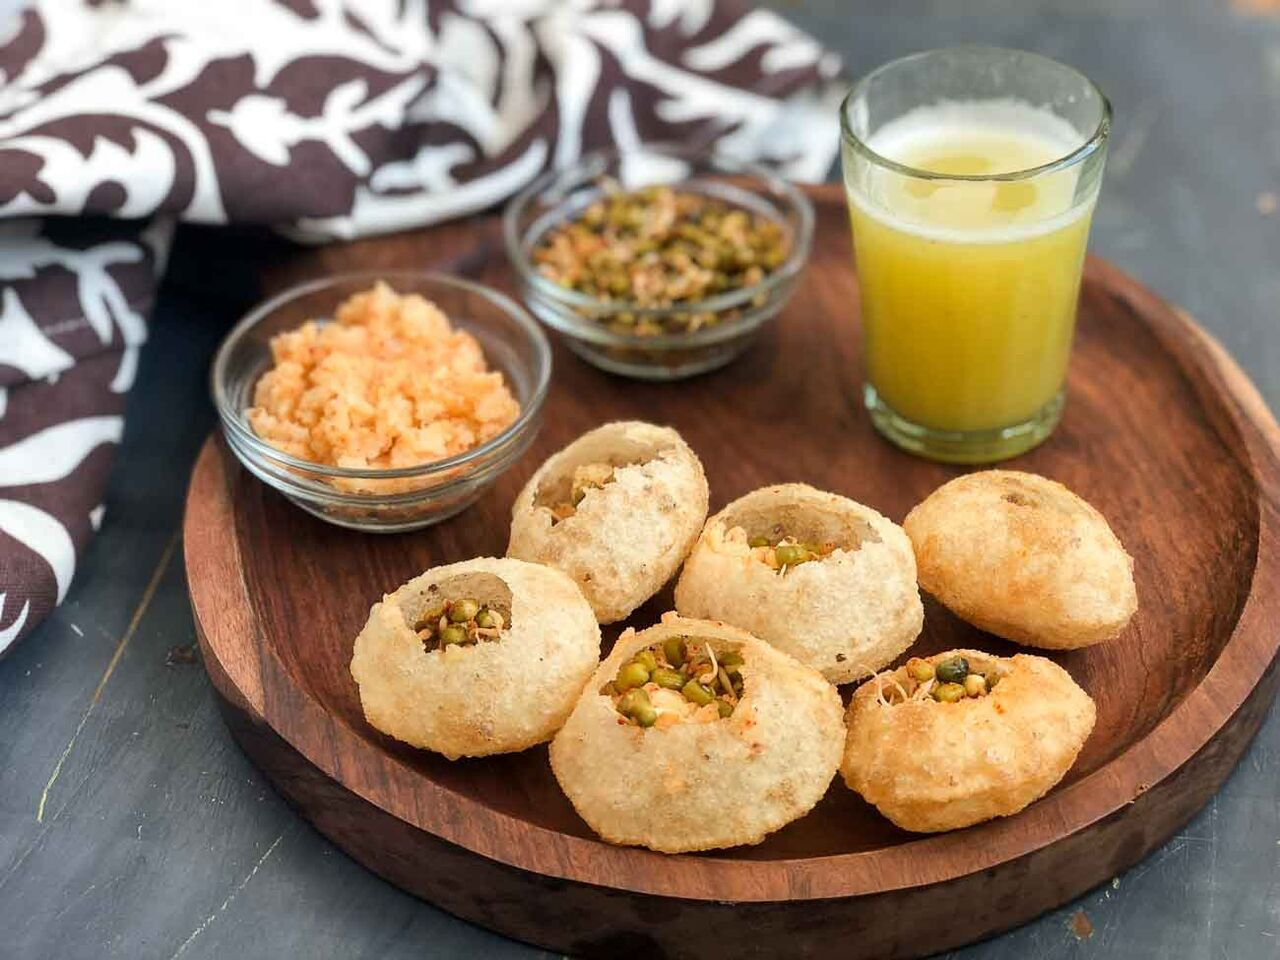

In [ ]:
image = ex['image']
image

In [ ]:
labels = data['train'].features['label']
labels

ClassLabel(num_classes=20, names=['burger', 'butter_naan', 'chai', 'chapati', 'chole_bhature', 'dal_makhani', 'dhokla', 'fried_rice', 'idli', 'jalebi', 'kaathi_rolls', 'kadai_paneer', 'kulfi', 'masala_dosa', 'momos', 'paani_puri', 'pakode', 'pav_bhaji', 'pizza', 'samosa'], id=None)

In [ ]:
labels.int2str(ex['label'])

'paani_puri'

## Fine-tuning a model on an image classification task

Next, let's fine-tune one of the [🤗 Transformers](https://github.com/huggingface/transformers) vision models on the Indian Food dataset.


Let us also load the Accuracy metric, which we'll use to evaluate our model both during and after training.

In [ ]:
from datasets import load_metric

metric = load_metric("accuracy")

The `dataset` object itself is a [`DatasetDict`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasetdict), which contains one key per split (in this case, only "train" for a training split).

In [ ]:
data

DatasetDict({
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 941
    })
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 5328
    })
})

Another prepatory step is to create an `id2label` dictionary to decode them back to strings and see what they are. The inverse `label2id` will be useful too, when we load the model later.

In [ ]:
labels = data["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

### Preprocessing the data

In [ ]:
from transformers import ViTFeatureExtractor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

Before we can feed these images to our model, we need to preprocess them. 

Preprocessing images typically comes down to (1) resizing them to a particular size (2) normalizing the color channels (R,G,B) using a mean and standard deviation. These are referred to as **image transformations**.

In addition, one typically performs what is called **data augmentation** during training (like random cropping and flipping) to make the model more robust and achieve higher accuracy. Data augmentation is also a great technique to increase the size of the training data.

We will use `torchvision.transforms` for the image transformations/data augmentation in this tutorial, but note that one can use any other package (like [albumentations](https://albumentations.ai/), [imgaug](https://github.com/aleju/imgaug), [Kornia](https://kornia.readthedocs.io/en/latest/) etc.).

To make sure we (1) resize to the appropriate size (2) use the appropriate image mean and standard deviation for the model architecture we are going to use, we instantiate what is called a feature extractor with the `AutoFeatureExtractor.from_pretrained` method.

This feature extractor is a minimal preprocessor that can be used to prepare images for inference.

The Datasets library is made for processing data very easily. We can write custom functions, which can then be applied on an entire dataset (either using [`.map()`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=map#datasets.Dataset.map) or [`.set_transform()`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=set_transform#datasets.Dataset.set_transform)).

Here we define 2 separate functions, one for training (which includes data augmentation) and one for validation (which only includes resizing, center cropping and normalizing). 

In [ ]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
train_transforms = Compose(
        [
            RandomResizedCrop(feature_extractor.size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(feature_extractor.size),
            CenterCrop(feature_extractor.size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

Next, we can preprocess our dataset by applying these functions. We will use the `set_transform` functionality, which allows to apply the functions above on-the-fly (meaning that they will only be applied when the images are loaded in RAM).

In [ ]:
# split up training into training + validation
train_ds = data['train']
val_ds = data['test']

In [ ]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

Let's access an element to see that we've added a "pixel_values" feature:

In [ ]:
train_ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=480x360 at 0x7FD911CAE650>,
 'label': 6,
 'pixel_values': tensor([[[-0.9608, -0.9529, -0.9529,  ..., -0.5686, -0.5373, -0.5294],
          [-0.9608, -0.9529, -0.9451,  ..., -0.5608, -0.6000, -0.6078],
          [-0.9843, -0.9843, -0.9765,  ..., -0.5451, -0.5608, -0.5216],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],
 
         [[-0.9608, -0.9529, -0.9529,  ..., -0.7255, -0.6784, -0.6471],
          [-0.9608, -0.9529, -0.9451,  ..., -0.7020, -0.7176, -0.7098],
          [-0.9843, -0.9843, -0.9765,  ..., -0.7098, -0.7176, -0.6784],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, 

### Training the model

Now that our data is ready, we can download the pretrained model and fine-tune it. For classification we use the `AutoModelForImageClassification` class. Calling the `from_pretrained` method on it will download and cache the weights for us. As the label ids and the number of labels are dataset dependent, we pass `label2id`, and `id2label` alongside the `model_checkpoint` here. This will make sure a custom classification head will be created (with a custom number of output neurons).

NOTE: in case you're planning to fine-tune an already fine-tuned checkpoint, like [facebook/convnext-tiny-224](https://huggingface.co/facebook/convnext-tiny-224) (which has already been fine-tuned on ImageNet-1k), then you need to provide the additional argument `ignore_mismatched_sizes=True` to the `from_pretrained` method. This will make sure the output head (with 1000 output neurons) is thrown away and replaced by a new, randomly initialized classification head that includes a custom number of output neurons. You don't need to specify this argument in case the pre-trained model doesn't include a head. 

In [ ]:
from transformers import ViTForImageClassification
model_name_or_path = 'google/vit-base-patch16-224-in21k'
model = ViTForImageClassification.from_pretrained(
    model_name_or_path, 
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The warning is telling us we are throwing away some weights (the weights and bias of the `classifier` layer) and randomly initializing some other (the weights and bias of a new `classifier` layer). This is expected in this case, because we are adding a new head for which we don't have pretrained weights, so the library warns us we should fine-tune this model before using it for inference, which is exactly what we are going to do.

To instantiate a `Trainer`, we will need to define the training configuration and the evaluation metric. The most important is the [`TrainingArguments`](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments), which is a class that contains all the attributes to customize the training. It requires one folder name, which will be used to save the checkpoints of the model.

Most of the training arguments are pretty self-explanatory, but one that is quite important here is `remove_unused_columns=False`. This one will drop any features not used by the model's call function. By default it's `True` because usually it's ideal to drop unused feature columns, making it easier to unpack inputs into the model's call function. But, in our case, we need the unused features ('image' in particular) in order to create 'pixel_values'.

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    'finetuned-indian-food',
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=True,
  report_to='tensorboard',
  load_best_model_at_end=True,
  hub_strategy="end"
)#

Here we set the evaluation to be done at the end of each epoch, tweak the learning rate, use the `batch_size` defined at the top of the notebook and customize the number of epochs for training, as well as the weight decay. Since the best model might not be the one at the end of training, we ask the `Trainer` to load the best model it saved (according to `metric_name`) at the end of training.

The last argument `push_to_hub` allows the Trainer to push the model to the [Hub](https://huggingface.co/models) regularly during training. Remove it if you didn't follow the installation steps at the top of the notebook. If you want to save your model locally with a name that is different from the name of the repository, or if you want to push your model under an organization and not your name space, use the `hub_model_id` argument to set the repo name (it needs to be the full name, including your namespace: for instance `"nielsr/vit-finetuned-cifar10"` or `"huggingface/nielsr/vit-finetuned-cifar10"`).

Next, we need to define a function for how to compute the metrics from the predictions, which will just use the `metric` we loaded earlier. The only preprocessing we have to do is to take the argmax of our predicted logits:

In [ ]:
import numpy as np

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

We also define a `collate_fn`, which will be used to batch examples together.
Each batch consists of 2 keys, namely `pixel_values` and `labels`.

In [ ]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

Then we just need to pass all of this along with our datasets to the `Trainer`:

In [ ]:
from transformers import Trainer
trainer = Trainer(
    model,
    training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

Cloning https://huggingface.co/rajistics/finetuned-indian-food into local empty directory.


Download file pytorch_model.bin:   0%|          | 3.47k/327M [00:00<?, ?B/s]

Download file runs/Jul15_18-54-00_8efc67140cef/events.out.tfevents.1657911381.8efc67140cef.6046.6:   5%|5     …

Download file runs/Aug03_21-01-32_cab156e75ca5/1659560685.1088154/events.out.tfevents.1659560685.cab156e75ca5.…

Download file runs/Jul15_18-54-00_8efc67140cef/events.out.tfevents.1657911262.8efc67140cef.6046.4:  41%|####  …

Download file runs/Jul15_18-54-00_8efc67140cef/1657911262.2402825/events.out.tfevents.1657911262.8efc67140cef.…

Download file runs/Jul15_18-54-00_8efc67140cef/1657911381.133698/events.out.tfevents.1657911381.8efc67140cef.6…

Download file runs/Aug03_21-01-32_cab156e75ca5/events.out.tfevents.1659560685.cab156e75ca5.72.0:  55%|#####4  …

Clean file runs/Aug03_21-01-32_cab156e75ca5/1659560685.1088154/events.out.tfevents.1659560685.cab156e75ca5.72.…

Download file 003.jpg:   0%|          | 3.49k/1.87M [00:00<?, ?B/s]

Clean file runs/Jul15_18-54-00_8efc67140cef/1657911262.2402825/events.out.tfevents.1657911262.8efc67140cef.604…

Clean file runs/Jul15_18-54-00_8efc67140cef/1657911381.133698/events.out.tfevents.1657911381.8efc67140cef.6046…

Clean file runs/Jul15_18-54-00_8efc67140cef/events.out.tfevents.1657911262.8efc67140cef.6046.4:  23%|##2      …

Clean file runs/Jul15_18-54-00_8efc67140cef/events.out.tfevents.1657911381.8efc67140cef.6046.6:   3%|3        …

Clean file runs/Aug03_21-01-32_cab156e75ca5/events.out.tfevents.1659560685.cab156e75ca5.72.0:   3%|3         |…

Download file training_args.bin: 100%|##########| 3.23k/3.23k [00:00<?, ?B/s]

Download file runs/Jul15_18-54-00_8efc67140cef/events.out.tfevents.1657914945.8efc67140cef.6046.8: 100%|######…

Clean file training_args.bin:  31%|###       | 1.00k/3.23k [00:00<?, ?B/s]

Clean file runs/Jul15_18-54-00_8efc67140cef/events.out.tfevents.1657914945.8efc67140cef.6046.8: 100%|#########…

Download file runs/Aug03_21-01-32_cab156e75ca5/events.out.tfevents.1659562835.cab156e75ca5.72.2: 100%|########…

Clean file runs/Aug03_21-01-32_cab156e75ca5/events.out.tfevents.1659562835.cab156e75ca5.72.2: 100%|##########|…

Clean file 003.jpg:   0%|          | 1.00k/1.87M [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/327M [00:00<?, ?B/s]

Using cuda_amp half precision backend


You might wonder why we pass along the `feature_extractor` as a tokenizer when we already preprocessed our data. This is only to make sure the feature extractor configuration file (stored as JSON) will also be uploaded to the repo on the hub.

Now we can finetune our model by calling the `train` method:

In [ ]:
train_results = trainer.train()
# rest is optional but nice to have
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 5328
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1332


Step,Training Loss,Validation Loss,Accuracy
100,1.179400,0.920808,0.856536
200,0.651300,0.540999,0.884166
300,0.590400,0.497848,0.879915
400,0.446100,0.366852,0.919235
500,0.563300,0.433989,0.884166
600,0.248900,0.335474,0.917109
700,0.317100,0.328614,0.919235
800,0.378500,0.323223,0.917109
900,0.227800,0.333829,0.919235
1000,0.089400,0.287036,0.924548


***** Running Evaluation *****
  Num examples = 941
  Batch size = 8
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
Saving model checkpoint to finetuned-indian-food/checkpoint-100
Configuration saved in finetuned-indian-food/checkpoint-100/config.json
Model weights saved in finetuned-indian-food/checkpoint-100/pytorch_model.bin
Feature extractor saved in finetuned-indian-food/checkpoint-100/preprocessor_config.json
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 10. 
  warnings.warn(str(msg))
***** Running Evaluation *****
  Num examples = 941
  Batch size = 8
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
Saving model checkpoint to finetuned-indian-food/c

Upload file pytorch_model.bin:   0%|          | 3.34k/327M [00:00<?, ?B/s]

Upload file runs/Aug04_18-07-39_26434d7bb3db/1659636699.575084/events.out.tfevents.1659636699.26434d7bb3db.71.…

Upload file runs/Aug04_18-07-39_26434d7bb3db/events.out.tfevents.1659636699.26434d7bb3db.71.0:  11%|#1        …

Upload file training_args.bin: 100%|##########| 3.23k/3.23k [00:00<?, ?B/s]

To https://huggingface.co/rajistics/finetuned-indian-food
   a1cbf3e..aeb260b  main -> main

To https://huggingface.co/rajistics/finetuned-indian-food
   aeb260b..3b64ca2  main -> main



***** train metrics *****
  epoch                    =          4.0
  total_flos               = 1538336014GF
  train_loss               =       0.4671
  train_runtime            =   0:26:57.22
  train_samples_per_second =       13.178
  train_steps_per_second   =        0.824


We can check with the `evaluate` method that our `Trainer` did reload the best model properly (if it was not the last one):

In [ ]:
metrics = trainer.evaluate()
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 941
  Batch size = 8


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =      0.933
  eval_loss               =     0.2632
  eval_runtime            = 0:00:37.39
  eval_samples_per_second =     25.167
  eval_steps_per_second   =      3.156


You can now upload the result of the training to the Hub, just execute this instruction (note that the Trainer will automatically create a model card as well as Tensorboard logs - see the "Training metrics" tab - amazing isn't it?):

In [ ]:
kwargs = {
    "finetuned_from": model.config._name_or_path,
    "tasks": "image-classification",
    "dataset": 'indian_food_images',
    "tags": ['image-classification'],
}

if training_args.push_to_hub:
    trainer.push_to_hub('🍻 cheers', **kwargs)
else:
    trainer.create_model_card(**kwargs)

Saving model checkpoint to finetuned-indian-food
Configuration saved in finetuned-indian-food/config.json
Model weights saved in finetuned-indian-food/pytorch_model.bin
Feature extractor saved in finetuned-indian-food/preprocessor_config.json


Upload file runs/Aug04_18-07-39_26434d7bb3db/events.out.tfevents.1659638706.26434d7bb3db.71.2: 100%|##########…

To https://huggingface.co/rajistics/finetuned-indian-food
   3b64ca2..2a7930a  main -> main

To https://huggingface.co/rajistics/finetuned-indian-food
   2a7930a..038f4f1  main -> main



You can now share this model with all your friends, family, favorite pets: they can all load it with the identifier `"your-username/the-name-you-picked"` so for instance:

```python
from transformers import AutoModelForImageClassification, AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained("rajistics/finetuned-indian-food")
model = AutoModelForImageClassification.from_pretrained("rajistics/finetuned-indian-food")

```

## Inference

Let's say you have a new image, on which you'd like to make a prediction. Let's load a image of XYZ and see how the model does.

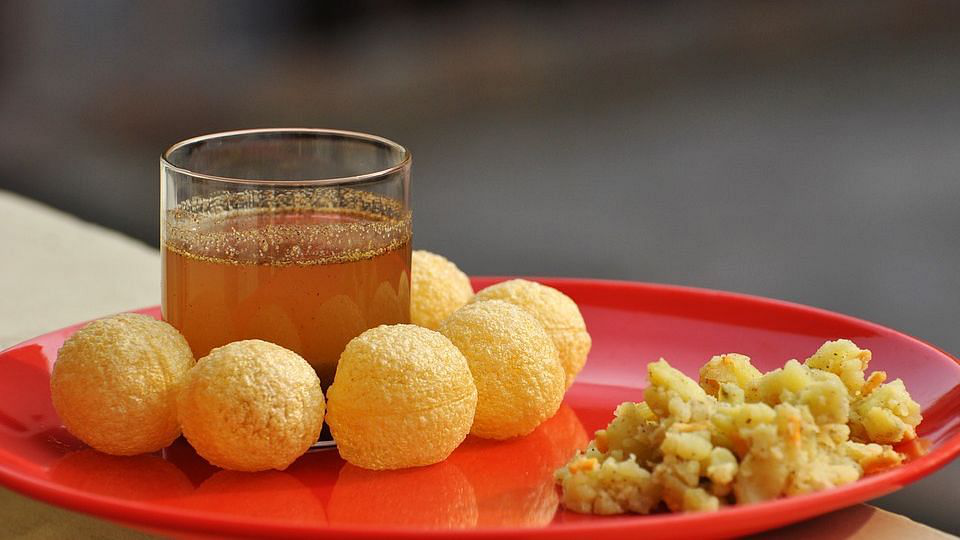

In [ ]:
from PIL import Image
import requests

url = 'https://huggingface.co/rajistics/finetuned-indian-food/resolve/main/126.jpg'
image = Image.open(requests.get(url, stream=True).raw)
image

We'll load the feature extractor and model from the hub (here, we use the [Auto Classes](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForImageClassification), which will make sure the appropriate classes will be loaded automatically based on the `config.json` and `preprocessor_config.json` files of the repo on the hub):

In [ ]:
from transformers import AutoModelForImageClassification, AutoFeatureExtractor

repo_name = "rajistics/finetuned-indian-food"

feature_extractor = AutoFeatureExtractor.from_pretrained(repo_name)
model = AutoModelForImageClassification.from_pretrained(repo_name)

loading feature extractor configuration file https://huggingface.co/rajistics/finetuned-indian-food/resolve/main/preprocessor_config.json from cache at /root/.cache/huggingface/transformers/b1437afde87880322f28c32d8d18e15087a6c0f5ebb3eb64022f3d2e70a30ecc.08655ed7bb323a517686dca7a2716a9fa479de0fa6b11dcf6906fa61e45c4490
Feature extractor ViTFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "size": 224
}

loading configuration file https://huggingface.co/rajistics/finetuned-indian-food/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/a8afbe01286a35191e954beb4d8beda8fc345ca5b9a5ed2e74fbb65e6d781a95.ec20cfd759c5caf4e631770632302266c6e79548e7f0b0e5f105ea2a6929826e
Model config ViTConfig {
  "_name_or_path": "rajistics/finetuned-indian-food",
  "architectures": [
    "ViTForImageClassifi

In [ ]:
# prepare image for the model
encoding = feature_extractor(image.convert("RGB"), return_tensors="pt")
print(encoding.pixel_values.shape)

torch.Size([1, 3, 224, 224])


In [ ]:
import torch

# forward pass
with torch.no_grad():
  outputs = model(**encoding)
  logits = outputs.logits

In [ ]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: paani_puri


Looks like our model got it correct! 

## Pipeline API

An alternative way to quickly perform inference with any model on the hub is by leveraging the [Pipeline API](https://huggingface.co/docs/transformers/main_classes/pipelines), which abstracts away all the steps we did manually above for us. It will perform the preprocessing, forward pass and postprocessing all in a single object. 

Let's showcase this for our trained model:

In [ ]:
from transformers import pipeline
pipe = pipeline("image-classification", "rajistics/finetuned-indian-food")

loading configuration file https://huggingface.co/rajistics/finetuned-indian-food/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/a8afbe01286a35191e954beb4d8beda8fc345ca5b9a5ed2e74fbb65e6d781a95.ec20cfd759c5caf4e631770632302266c6e79548e7f0b0e5f105ea2a6929826e
Model config ViTConfig {
  "_name_or_path": "rajistics/finetuned-indian-food",
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "burger",
    "1": "butter_naan",
    "2": "chai",
    "3": "chapati",
    "4": "chole_bhature",
    "5": "dal_makhani",
    "6": "dhokla",
    "7": "fried_rice",
    "8": "idli",
    "9": "jalebi",
    "10": "kaathi_rolls",
    "11": "kadai_paneer",
    "12": "kulfi",
    "13": "masala_dosa",
    "14": "momos",
    "15": "paani_puri",
    "16": "pakode",
    "17": "pav_bhaji",
    "18": "pizza",
    "19": 

In [ ]:
url = 'https://huggingface.co/rajistics/finetuned-indian-food/resolve/main/126.jpg'
image = Image.open(requests.get(url, stream=True).raw)

pipe(image)

[{'label': 'paani_puri', 'score': 0.9596387147903442},
 {'label': 'chai', 'score': 0.0037827605847269297},
 {'label': 'pakode', 'score': 0.0034946436062455177},
 {'label': 'chole_bhature', 'score': 0.003195039462298155},
 {'label': 'kaathi_rolls', 'score': 0.002916843630373478}]

As we can see, it does not only show the class label with the highest probability, but does return the top 5 labels, with their corresponding scores. Note that the pipelines also work with local models and feature extractors:

In [ ]:
pipe = pipeline("image-classification", 
                model=model,
                feature_extractor=feature_extractor)

In [ ]:
pipe(image)

[{'label': 'paani_puri', 'score': 0.9596387147903442},
 {'label': 'chai', 'score': 0.0037827605847269297},
 {'label': 'pakode', 'score': 0.0034946436062455177},
 {'label': 'chole_bhature', 'score': 0.003195039462298155},
 {'label': 'kaathi_rolls', 'score': 0.002916843630373478}]